<div style="max-width: 800px; margin: 0 auto; text-align: justify;">

<h1>Notebook 1: Monte Carlo Markov Chains Background</h1>

<h2>Structure</h2>

| Part | Topic | Type |
|:----:|-------|------|
| 1 | Recap: Where We Left Off | Conceptual |
| 2 | The Drunkard's Walk: An Intuition for MCMC | Conceptual |
| 3 | Metropolis-Hastings | Technical |
| 4 | Gibbs Sampling | Technical |
| 5 | Hamiltonian Monte Carlo | Technical |
| 6 | NUTS and Ensemble Samplers | Technical |
| 7 | When to Use What | Reference |
| 8 | The Language of MCMC: A Glossary | Reference |
| 9 | What Can Go Wrong: A Preview | Conceptual |
| 10 | Software: NumPyro in 60 Seconds | Practical |


<h2>Preamble</h2>

- What this covers
- Won't be required to write code, only run it
- An installation check will be performed
- Reading Guide: Sections marked with "🏛️ **Historical Aside**" are anecdotes and context. They are completely skippable, but can be fun.
</div>


<div style="max-width: 800px; margin: 0 auto; text-align: justify;">

<h1>Recap: Where We Left Off</h1>

In previous tutorials, we defined Bayes Theorem:
$$P(\theta \mid D) = \frac{\mathcal{L}(\theta) \, \pi(\theta)}{\mathcal{Z}}$$
Recall that each of the are:
- $P(\theta|D)$ - The posterior, i.e. what we believe about our parameters *after* seeing the data.
- $\mathcal{L}(\theta)$ - The likelihood, i.e. the probability of seeing the data given a particular set of parameters (the physics and the noise).
- $\pi(\theta)$ - The prior, i.e. what we believe about our parameters *before* seeing the data
- $\mathcal{Z}$ - The evidence, i.e. the total probability of observing your data, averaged over all parameter values weighted by the prior. In practice, treated as a normalisation constant.

The nice thing about Bayes theorem, is that if we only care about parameter estimation (and not model comparison), we can treat the evidence as a normalisation constant and drop it, leaving:

$$P(\theta \mid D) \propto \mathcal{L}(\theta) \, \pi(\theta)$$

If you do care about model comparison, go back to the Nested Sampling notebook.

In the Bayes 101 notebook, we fit a model to a spectral line by doing a grid search. This model had 4 parameters, we fixed two of them, and tested 250 values each for the other two parameters. This meant, that in total, we tested $250^2 = 62,500$ parameter combinations. If we didn't fix the other two, we would have had to test $250^4 \approx 3.9$ billion parameter combinations. Obviously this is way too many to check. This problem is known as the curse of dimensionality. The basic problem is that high dimensional spaces have a lot of volume, most of which we don't care about. Let's see this in practice by using Monte Carlo methods

-----------

# 🏛️ Historical Aside: Monte Carlo
<div style="text-align: center;">
  <img src="Images/MonteCarlo.png" style="max-width: 70%; border-radius: 4px;">
    <p style="font-size: 0.75em; color: #888; font-style: italic; margin-top: 0.5em; text-align: center;">
    Left: A poster depicting the facade of the Monte Carlo Casino at sunset, by Mario Borgoni, c. 1910. Right: 'Souvenir de Monte Carlo' postcard, c. late 1800s, featuring a roulette wheel, and a lady on a donkey, likely a depiction of "lady luck".
  </p>
</div>

### Name:

Monte Carlo is a region within the city state of Monaco (near the French and Italian border). The Casino de Monte-Carlo was opened in 1863 to save the state from bankruptcy. The casino was so successful that income tax in Monaco was abolishd in 1869. It is likely the most famous casino in the world, and is the casino that inspired the casino in the James Bond novel and movie "Casino Royale".

### Connection to Statistics:
Like suprisingly many physics and statistics inventions, Monte Carlo methods origniated during the Manhatten Project (i.e. the nuclear bomb project) at Los Alamos. The Monte Carlo method was invented by Stanislaw Ulam and later formalised with the help of John von Neumann.

#### Stanislaw Ulam

Stanislaw Ulam was a Polish-Born (later American) mathematician. He and his brother left Poland to the USA on a voyage funded by his father and uncle. Eleven days after departure, the Nazis had invaded Poland which they took over within two months. Within two years, most of his family was murdered during the Holocaust. 
In 1943, he (may have) asked John von Neumann (who he had met several years earlier in Warsaw) to find him a war job. In October, he was sent an invitation to join an unidentified project in New Mexico. At the time, he was working at the University of Wisconsin-Madison. As he knew little of New Mexico, he checked out a New Mexico guide book from the university library. In the checkout card inside the guide book, the names of several of his colleagues appeared, all of whom had disappeared to work on the Manhatten Project.

In 1946, he suffered from encephalitis -- a severe, life-threatening inflammation of the brain. This temporarily led to cognitive impairment (difficulty with mathematics, memory issues, etc). During his recovery, he had to relearn basic mathematics. While recovering, he played the solo card game solitare frequently and obsessively. While doing so, he started to wonder about the probability of a successful game. Rather than doing difficult combinatorial analysis, he realised that brute-force random sampling would be easier. This is where the Monte-Carlo method oringates from. Allegedly, Nicholas Metropolis coined the name Monte-Carlo after Ulams fathers gambling problem and the name stuck. 

Unlike many of his Manhatten project colleagues, he was neither a nuclear hawk nor dove. Perhaps the reason that he did not become a dove was because the project was ostenstibly started in order to defeat the Nazis (who murdered most of his family), and not the Japanese. He did later support anti-nuclear testing treaties.

----------------

</div>

<div style="max-width: 800px; margin: 0 auto; text-align: justify;">

# Estimating $\pi$ using Monte Carlo Methods

The core idea is simple: *If computing something analytical is hard, throw random numbers at it and count.*

This is a classic example that uses random sampling to estimate the value of $\pi$. You likely have done this in your first computational physics class. 

Consider a square with a sidelength 2, centred at the origin (so $x,y \in [-1,1]$), with a circled inscribed within it. 
- The area of the square: $A_\text{square} = 2 \times 2 = 4$
- The area of the square: $A_\text{circle} = \pi r^2 = \pi$

The ratio of areas is then:

$$ \frac{A_\text{circle}}{A_\text{square}} = \frac{\pi}{4} $$

We will (uniformly) randomly sample points on a two-dimensional plane with limits of [-1, 1], and we will count the number of points that land within a circle of radius 1. If we assume that the number of points within the circle and outside the circle are proportional to the respective areas (which uniform sampling guarantees in expectation), then the fraction of points landing inside the circle convergess to the fraction of the areas:

$$ \frac{N_\text{inside}}{N_\text{total}} \xrightarrow{N \to \infty} \frac{A_\text{circle}}{A_\text{square}} = \frac{\pi}{4}$$

Rearranging, we get:

$$ \pi \approx 4 \times \frac{N_\text{inside}}{N_\text{total}}$$
</div>

## Define the Geometry

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.special import gamma

In [ ]:
# Draw Circle
t = np.linspace(0,2*np.pi, 360)
circ_x = np.cos(t)
circ_y = np.sin(t)

plt.figure(figsize = (4,4))
plt.plot(circ_x, circ_y, ls = '--')
plt.axis('equal')
plt.xlim([-1, 1])
plt.ylim([-1, 1])

In [ ]:
# Set Seed
np.random.seed(161)

# Define arrays to keep track of things
x_samples = []
y_samples = []
inside_mask = []
running_pi_estimate = []

num_samples = 10000
plot_idxs = [10, 100, 1000, 5000, 10000]


# note this is not an efficient implementation
for i in tqdm(range(num_samples)):
    # draw sample
    x = np.random.uniform(low = -1, high = 1, size = 1)
    y = np.random.uniform(low = -1, high = 1, size = 1)
    x_samples.append(x)
    y_samples.append(y)

    # check if point is within circle
    inside = (x**2 + y**2) <= 1
    inside_mask.append(inside)

    # estimate pi
    pi_estimate = 4 * np.sum(inside_mask) / len(x_samples)
    running_pi_estimate.append(pi_estimate)

    # plot
    if i+1 in plot_idxs:
        x_arr = np.array(x_samples).flatten()
        y_arr = np.array(y_samples).flatten()
        mask = np.array(inside_mask).flatten()
        plt.figure(figsize = (4,4))
        plt.plot(circ_x, circ_y, ls = '--')
        plt.scatter(x_arr[mask], y_arr[mask], color = 'tab:red', s = 2)
        plt.scatter(x_arr[~mask], y_arr[~mask], color = 'black', s = 2)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlim([-1.05, 1.05])
        plt.ylim([-1.05, 1.05])  
        plt.title(f'Iterations: {i+1} \n Pi Estimate {pi_estimate}')
        plt.show()

<div style="max-width: 800px; margin: 0 auto; text-align: justify;">


Let's now track the estimate over time. As $N$ increases, our estimate for $\pi$ should converge to the true value. Since each sample is an independent test, either in or outside the circle (a.k.a. a Bernoulli trial) with success probability $p = \pi/4$, the central limit theorem tells us that the standard error on our estimate is:

$$ \sigma_\pi = 4 \sqrt{\frac{p(1-p)}{N}} \sim \frac{1}{\sqrt{N}}$$

The $\frac{1}{\sqrt{N}}$ scaling is the generic Monte Carlo convergence rate.

</div>

In [ ]:
# Uncertainty estimates
N_arr  = np.arange(1, len(running_pi_estimate) + 1)
pi_est = np.array(running_pi_estimate)
p      = np.pi / 4
envelope = 4 * np.sqrt(p * (1 - p) / N_arr)

# plot
plt.figure(figsize = (15, 10))

plt.subplot(2,1,1)
plt.plot(running_pi_estimate, label = r'$\pi$-estimate')
plt.hlines(np.pi, 0, len(running_pi_estimate), ls = '--', color = 'black', label = r'True $\pi$ value')
plt.legend()
plt.xlim(0, len(running_pi_estimate))
plt.xlabel('Iterations')
plt.ylabel(r'$\pi$ estimate')

plt.subplot(2,1,2)
plt.plot(running_pi_estimate, label = r'$\pi$-estimate')
plt.fill_between(N_arr-1, pi_est - envelope, pi_est + envelope,
                 alpha = 0.2, color = 'steelblue', label = r'$1\sigma$ ($\sim 1/\sqrt{N}$)')

plt.hlines(np.pi, 0, len(running_pi_estimate), ls = '--', color = 'black', label = r'True $\pi$ value')
plt.legend()
plt.xlim(1, len(running_pi_estimate))
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel(r'$\pi$ estimate')

<div style="max-width: 800px; margin: 0 auto; text-align: justify;">

## Geometry to Integrals

What we just did is **Monte Carlo integration**. The area of the circle is:

$$A_\text{circle} = \int_{-1}^{1}\int_{-1}^{1} \mathbb{1}[x^2 + y^2 \leq 1] \, dx \, dy$$

where:

$$ \mathbb{1}[x^2 + y^2 \leq 1] = \begin{cases} 1 & \text{if } x^2 + y^2 \leq 1 \\ 0 & \text{otherwise} \end{cases}$$

Rather than analytically calculating the area of a circle, in this case we could have calculated the integral using a grid search. This is fine in two-dimensions, but not practicle in higher dimensions. Instead, we approximated it by sampling:

$$A_\text{circle} \approx \frac{A_\text{square}}{N} \sum_{i=1}^{N} \mathbb{1}[x_i^2 + y_i^2 \leq 1]$$

This is just a fancy way of saying we did random sampling. But the point is that this generalises. For *any* integral $I = \int f(\mathbf{x}) \, d\mathbf{x}$ over some domain, we can estimate it by drawing uniform samples $\mathbf{x}_i$ and computing the average of $f(\mathbf{x}_i)$ scaled by the volume of the domain:


$$I \approx \frac{V}{N} \sum_{i=1}^{N} f(\mathbf{x}_i)$$

Importantly, the convergence rate $\sim 1/\sqrt{N}$ is independent of dimensionality. Grid based numerical integration scales as $N^d$ (The curse of dimensionality). Monte Carlo does not. 

## The Efficiency Catch

In 2D, about $\pi/4 \approx 78.5\%$ of our samples land inside the circle, most of our random throws are "useful". This is rarely the case in higher dimensions. 

Consider the analogous problem: a $d$-dimensional unit hypersphere inscribed in a $d$-dimensional hypercube with side length 2. The volume of a hypercube is:

$$ V_\text{hypercube} = s^d $$

The volume of a hypersphere is:

$$ V_\text{hypersphere} = \frac{\pi^{d/2}}{\Gamma(\frac{d}{2}+1)} r^d$$

Here, $\Gamma$ is [Euler's Gamma function](https://en.wikipedia.org/wiki/Gamma_function). Let's plot the number of useful samples over time (i.e. the samples within the hypersphere)

</div>

In [ ]:
# dimensions
d = np.arange(1, 26)

# Calcalate volumes
hypercube_volume = 2**d
hypersphere_volume = ((np.pi**(d/2)) / (gamma(d/2 + 1))) * 1**d
frac = hypersphere_volume / hypercube_volume


plt.figure(figsize = (6,5))
plt.plot(d, frac, '-o')
plt.xlabel('Dimensions')
plt.ylabel('Volume ratio')
plt.yscale('log')

print(f"d=2:  {frac[1]:.4f}  (1 in ~{1/frac[1]:.1f} samples useful)")
print(f"d=5:  {frac[4]:.4f}  (1 in ~{1/frac[4]:.0f} samples useful)")
print(f"d=10: {frac[9]:.2e}  (1 in ~{1/frac[9]:.0f} samples useful)")
print(f"d=20: {frac[19]:.2e}  (1 in ~{1/frac[19]:.0f} samples useful)")


<div style="max-width: 800px; margin: 0 auto; text-align: justify;">
As dimensionality increases, the sphere occupies a vanishing fraction of the cube. Almost every random sample lands outside the sphere. They are not "wasted" (they still contribute to the estimate), but the signal-to-noise ratio becomes catastrophic. This is the fundamental problem with naive Monte Carlo in high dimensions. The interesting region, whether its a geometeric shape, or the high probability region of a posterior distribution becomes incredibly small. 

This is the problem MCMC solves. Instead of throwing darts uniformly and hoping they land somewhere useful, MCMC constructs a random walk that preferentially visits the interesting region. The samples are no longer independent (they form a correlated chain), and they're no longer uniform (they're drawn from the target distribution$^1$). But they're efficient. Every sample is, in some sense, useful.

*$^1$ We will come back to the importance of these points shortly.*

---------------
</div>

Time to add a historical aside about how and why to MC was needed for fissile bombs

<div style="max-width: 800px; margin: 0 auto; text-align: justify;">

<h1>Markov Chains</h1>

We have the "Monte Carlo" part. But naive Monte Carlo (throwing darts uniformly) fails in high dimensions because the interesting region is a vanishingly small fraction of the total volume. We need a smarter way to generate random samples, one that concentrates its effort where it matters. This is where Markov Chains come in (the second MC in MCMC).

<h2>A Simple Example: Observing at the AAT</h2>

Those of you who have observed at the Anglo-Australian Telescope at Siding Spring will know that roughly a third of nights are lost to weather (rain, fog, lightning, clouds, etc). But anyone who has actually been on a run knows that bad weather is *not* randomly sprinkled across the schedule. Bad nights come in streaks. If tonight is closed, tomorrow is more likely to be closed too. The same front that shut you down doesn't vanish overnight. Conversely, a clear night is a good omen for the next one.

The overall 33% loss rate is an average over all nights. But the night-to-night weather is **correlated**. 

Let's model AAT weather as a two-state Markov chain: Open and Closed. The weather tomorrow depends only on the weather tonight:

- If tonight is open, there's a 80% chance tomorrow is open and a 20% chance tomorrow is closed.
- If tonight is closed, there's a 40% chance tomorrow is open and a 60% chance tomorrow is closed.

<div style="text-align: center;">
  <img src="Images/MarkovChain.PNG" style="max-width: 70%; border-radius: 4px;">
</div>


We can write this as a transition matrix:

$$T = \begin{pmatrix} 0.80 & 0.20 \\ 0.40 & 0.60 \end{pmatrix}$$

where $T_{ij}$ is the probability of going from state $i$ to state $j$. This is a Markov chain: the weather tomorrow depends *only* on the weather tonight, not on the entire history of the run. This is called the memoryless property. You might see this written as such:

$$P(\theta_{n+1} \mid \theta_n, \theta_{n-1}, \ldots, \theta_0) = P(\theta_{n+1} \mid \theta_n)$$

This just says that the probability of the next state being conditional on all previous states is the same as the probability of the next state being conditional on only the prior state. 

Note: in reality, weather isn't perfectly Markov but it's a decent approximation, and it captures the essential point: the overall rate (33% closed) emerges from correlated night-to-night transitions, not from independent coin flips.

</div>

In [29]:
# Transition matrix: rows = current state, columns = next state
# State 0 = Open, State 1 = Closed
T = np.array([[0.80, 0.20],
              [0.40, 0.60]])

# Simulate an observing season
np.random.seed(42)
n_nights = 365
weather = np.zeros(n_nights, dtype=int)
weather[0] = 0  # first night is open

for i in range(1, n_nights):
    weather[i] = np.random.choice([0, 1], p=T[weather[i-1]])

# Running fraction of open nights
open_fraction = np.cumsum(weather == 0) / np.arange(1, n_nights + 1)

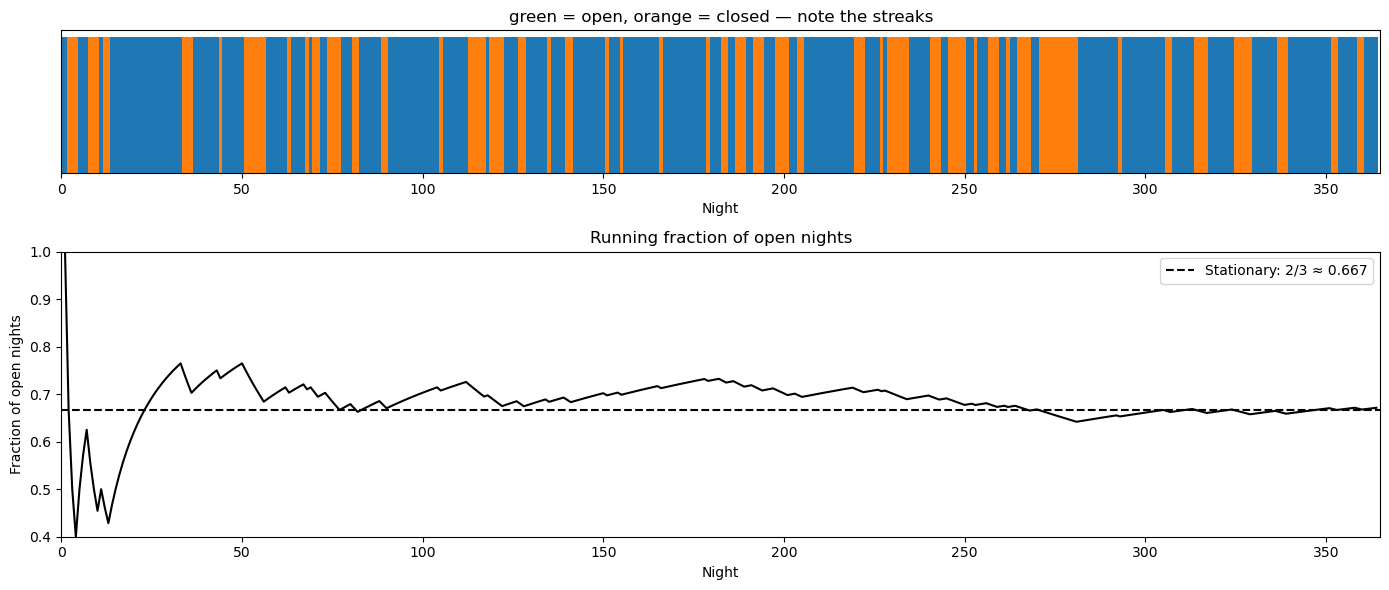

In [30]:
# plot schedule

fig, axes = plt.subplots(2, 1, figsize=(14, 6), gridspec_kw={'height_ratios': [1, 2]})

colors = ['tab:blue' if w == 0 else 'tab:orange' for w in weather[:365]]
axes[0].bar(range(365), np.ones(365), color=colors, width=1.0, edgecolor='none')
axes[0].set_xlim(0, 365)
axes[0].set_yticks([])
axes[0].set_xlabel('Night')
axes[0].set_title('green = open, orange = closed — note the streaks')

# Bottom convergence of open fraction
axes[1].plot(open_fraction, color='black', lw=1.5)
axes[1].axhline(2/3, ls='--', color='black', label=f'Stationary: 2/3 ≈ 0.667')
axes[1].set_xlabel('Night')
axes[1].set_ylabel('Fraction of open nights')
axes[1].set_title('Running fraction of open nights')
axes[1].legend()
axes[1].set_xlim(0, n_nights)
axes[1].set_ylim(0.4, 1.0)

plt.tight_layout()
plt.show()

<div style="max-width: 800px; margin: 0 auto; text-align: justify;">

<h2>The Stationary Distribution</h2>

Look at the top panel. The weather comes in streaks, runs of open nights followed by runs of closures. On any given night, the weather is correlated with the night before. Yet, the bottom panel shows that the running fraction of open nights converges to a stable value, regardless of whether the season started clear or cloudy.

This stable value is the **stationary distribution** $\boldsymbol{\pi}^*$. It satisfies:

$$\boldsymbol{\pi}^* = \boldsymbol{\pi}^* T$$

In words: if the chain is currently distributed according to $\boldsymbol{\pi}^*$, then after one transition it's *still* distributed according to $\boldsymbol{\pi}^*$. The distribution is self-perpetuating. So the chain predicts a 33% closure rate, matching the AAT weather statistics.

Let's verify that the chain converges to this regardless of starting conditions:

</div>

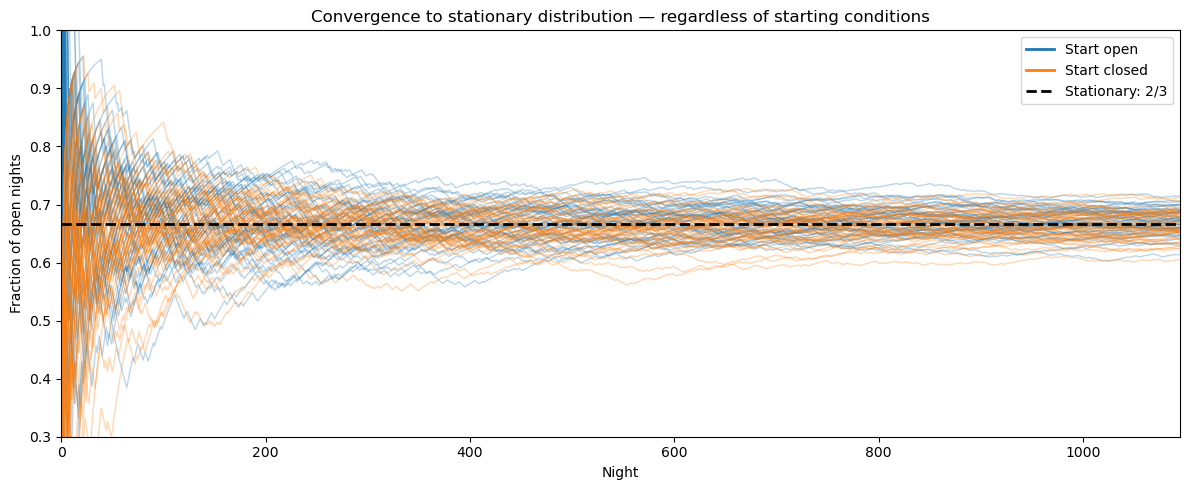

In [31]:
fig, ax = plt.subplots(figsize=(12, 5))

n_nights = 3*365

for start_state, color, label in [(0, 'tab:blue', 'Start open'), (1, 'tab:orange', 'Start closed')]:
    for trial in range(50):
        weather = np.zeros(n_nights, dtype=int)
        weather[0] = start_state
        for i in range(1, n_nights):
            weather[i] = np.random.choice([0, 1], p=T[weather[i-1]])
        open_frac = np.cumsum(weather == 0) / np.arange(1, n_nights + 1)
        ax.plot(open_frac, color=color, alpha=0.3, lw=1)

    ax.plot([], [], color=color, label=label, lw=2)

ax.axhline(2/3, ls='--', color='black', label='Stationary: 2/3', lw=2)
ax.set_xlabel('Night')
ax.set_ylabel('Fraction of open nights')
ax.set_title('Convergence to stationary distribution — regardless of starting conditions')
ax.legend()
ax.set_xlim(0, n_nights)
ax.set_ylim(0.3, 1.0)
plt.tight_layout()
plt.show()

<div style="max-width: 800px; margin: 0 auto; text-align: justify;">

<h2>Extending to Continuous Distributions</h2>

The AAT weather chain had two states. But most quantities we care about in astronomy are continuous: seeing, flux, temperature, redshift, metaliccity. Can a Markov chain produce a continuous stationary distribution?

Let's stay at the AAT, but instead of tracking whether the dome is open or closed, track the seeing (FWHM in arcseconds) hour by hour through an observing season. The seeing at AAT has a few key properties:
- The median is around 1.5"
- It's positively skewed — you occasionally get terrible 3–4" conditions, but rarely get sub-arcsecond seeing
- It's correlated hour to hour — a period of good seeing is more likely to be followed by another hour of good seeing than a random draw from the overall distribution (similar atmospheric conditions persist)

We can model this as a Markov chain in exactly the same spirit as the weather example. Instead of a transition matrix, we have a transition rule: this hour's seeing depends on the previous hour's seeing, plus some noise, with a tendency to drift back toward the site's typical value. This is an autoregressive process (AR(1)) — "autoregressive" just means "the next value depends on the previous value," which is exactly the Markov property. The "(1)" means it only looks back one step.

The transition rule is:

$$s_{n+1} = \mu + \alpha\,(s_n - \mu) + \varepsilon, \qquad \varepsilon \sim \mathcal{N}(0,\, \sigma^2)$$

where:
- $s_n$ is the (log-)seeing at hour $n$
- $\mu$ is the long-run average log-seeing for the site (i.e. what the seeing "wants" to be)
- $\alpha$ is the **persistence** parameter ($0 \leq \alpha < 1$). High $\alpha$ means the seeing this hour strongly resembles last hour; $\alpha = 0$ means no memory at all
- $\varepsilon$ is a random perturbation, sampled from a normal distribution
- $\sigma$ controls the size of that fluctuation

Read it as: "next hour's seeing = the site average, plus a fraction $\alpha$ of however far the current seeing is from that average, plus random noise." The $\alpha(s_n - \mu)$ term is mean reversion: if the seeing is currently worse than average, it tends to drift back, but not all at once.


</div>

In [33]:
def simulate_seeing(mu_log, alpha, sigma, n_hours, start=None):
    """Simulate a Markov chain of seeing values (FWHM) via AR(1) in log-space."""
    log_seeing = np.zeros(n_hours)
    log_seeing[0] = start if start is not None else mu_log
    
    for i in range(1, n_hours):
        log_seeing[i] = mu_log + alpha * (log_seeing[i-1] - mu_log) + np.random.normal(0, sigma)
    
    return np.exp(log_seeing)  # convert back to arcseconds

In [37]:
# AAT: median ~1.5", skewed, moderate persistence
aat_seeing = simulate_seeing(mu_log=np.log(1.5), alpha=0.8, sigma=0.25, n_hours=5000, start=np.log(3.0))

# Mauna Kea: median ~0.6", tighter, similar persistence  
mk_seeing = simulate_seeing(mu_log=np.log(0.6), alpha=0.8, sigma=0.18, n_hours=5000, start=np.log(2.0))

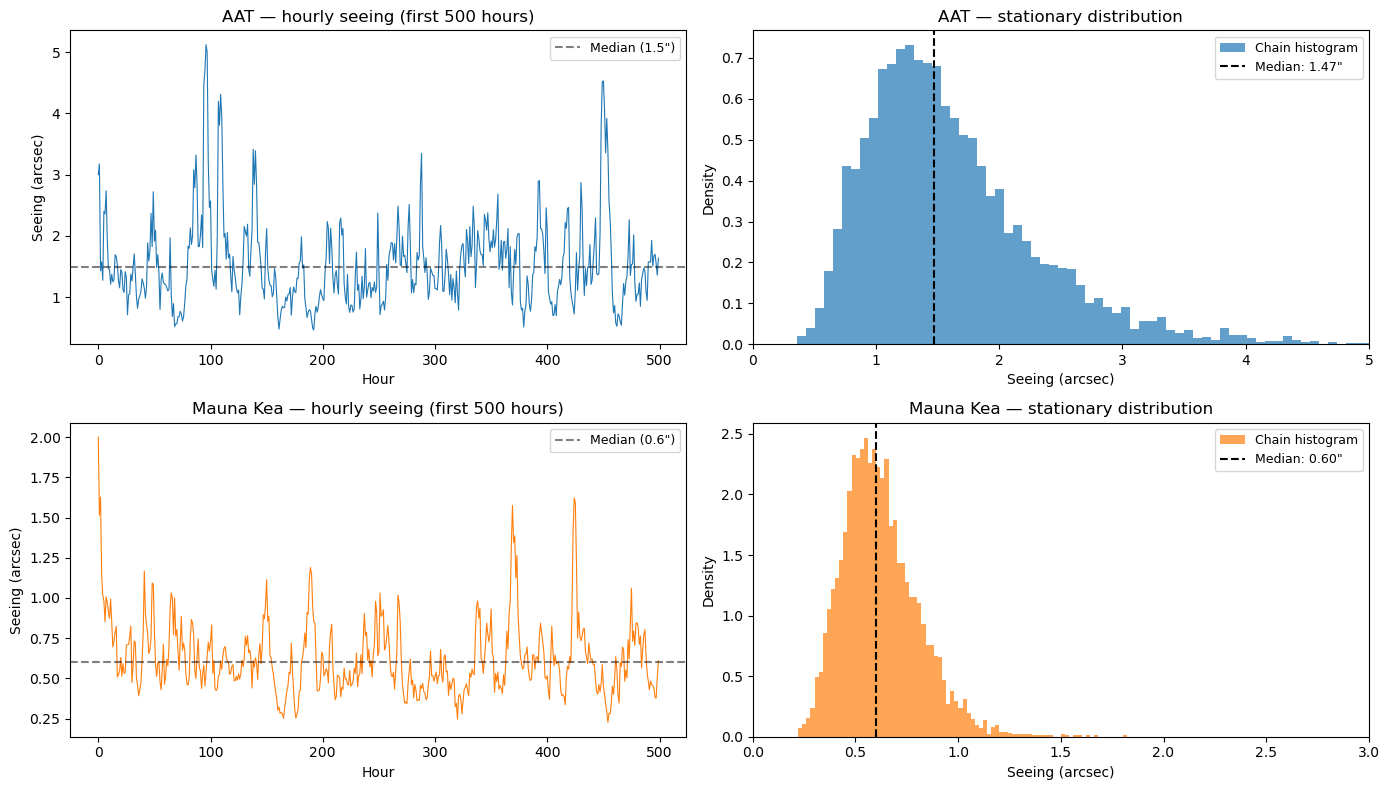

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# --- Top row: AAT ---
axes[0, 0].plot(aat_seeing[:500], lw=0.8, color='tab:blue')
axes[0, 0].set_ylabel('Seeing (arcsec)')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_title('AAT — hourly seeing (first 500 hours)')
axes[0, 0].axhline(1.5, ls='--', color='black', alpha=0.5, label='Median (1.5")')
axes[0, 0].legend(fontsize=9)

axes[0, 1].hist(aat_seeing[200:], bins=80, density=True, alpha=0.7, color='tab:blue', label='Chain histogram')
axes[0, 1].axvline(np.median(aat_seeing[200:]), ls='--', color='black', label=f'Median: {np.median(aat_seeing[200:]):.2f}"')
axes[0, 1].set_xlabel('Seeing (arcsec)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('AAT — stationary distribution')
axes[0, 1].set_xlim(0, 5)
axes[0, 1].legend(fontsize=9)

# --- Bottom row: Mauna Kea ---
axes[1, 0].plot(mk_seeing[:500], lw=0.8, color='tab:orange')
axes[1, 0].set_ylabel('Seeing (arcsec)')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_title('Mauna Kea — hourly seeing (first 500 hours)')
axes[1, 0].axhline(0.6, ls='--', color='black', alpha=0.5, label='Median (0.6")')
axes[1, 0].legend(fontsize=9)

axes[1, 1].hist(mk_seeing[200:], bins=80, density=True, alpha=0.7, color='tab:orange', label='Chain histogram')
axes[1, 1].axvline(np.median(mk_seeing[200:]), ls='--', color='black', label=f'Median: {np.median(mk_seeing[200:]):.2f}"')
axes[1, 1].set_xlabel('Seeing (arcsec)')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Mauna Kea — stationary distribution')
axes[1, 1].set_xlim(0, 3)
axes[1, 1].legend(fontsize=9)

plt.tight_layout()
plt.show()

<div style="max-width: 800px; margin: 0 auto; text-align: justify;">

The left panels show the trace: the sequence of seeing values hour after hour. Notice the streaks: runs of good seeing and runs of bad seeing, just like the open/closed weather streaks. Each hour's seeing depends on the previous hour. The samples are correlated.

The right panels show the histograms of those chains i.e. the stationary distributions. Both are continuous, skewed, and positive. They look like real seeing distributions because the same underlying physics (persistent atmospheric conditions with random perturbations) is what produces the Markov property in real weather.

The AAT chain settles into a distribution peaked around 1.5" with a heavy tail toward 4". The Mauna Kea chain settles around 0.6" with a tighter spread. The takeaway is that the shape of the stationary distribution is entirely determined by the transition rules.

Now, notice what we did *not* do. We never wrote down the stationary distribution analytically. We never said "the seeing follows a log-normal with these parameters." We defined a transition rule (how this hour relates to the previous hour), ran the chain, and the stationary distribution *emerged*.

**MCMC does this in reverse.** We *start* with a target distribution (the posterior $P(\theta|D)$) and we engineer transition rules such that the chain's stationary distribution is exactly that target. The chain then produces samples from the posterior, and the histogram of those samples converges to the posterior shape.

The question is: how do we engineer those transition rules?

-----------

</div>

In [ ]:
# circle example, then onto Markov chains)